- https://wikidocs.net/44249

## 모듈

In [1]:
import re
import numpy as np
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 데이터 로딩

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x25134b945e0>)

In [3]:
train=pd.read_table('ratings_train.txt')
test=pd.read_table('ratings_test.txt')

In [4]:
train.head(5)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [5]:
test.head(5)

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [6]:
print(f'train 갯수 : {train.shape}, test 갯수 : {test.shape}')

train 갯수 : (150000, 3), test 갯수 : (50000, 3)


### 훈련
---

In [7]:
train['document'].unique(), train['label'].unique()

(array(['아 더빙.. 진짜 짜증나네요 목소리', '흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나',
        '너무재밓었다그래서보는것을추천한다', ..., '이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?',
        '청춘 영화의 최고봉.방황과 우울했던 날들의 자화상', '한국 영화 최초로 수간하는 내용이 담긴 영화'],
       dtype=object),
 array([0, 1], dtype=int64))

In [8]:
# document 열과 label 열의 중복을 제외한 값의 개수
train['document'].nunique(), train['label'].nunique()

(146182, 2)

In [9]:
# document 열의 중복 제거
train.drop_duplicates(subset=['document'], inplace=True)

In [10]:
len(train)

146183

In [11]:
train['label'].value_counts()

0    73342
1    72841
Name: label, dtype: int64

In [12]:
train.groupby('label').count()

,id,document
label,,
0,73342,73342
1,72841,72840


<AxesSubplot:>

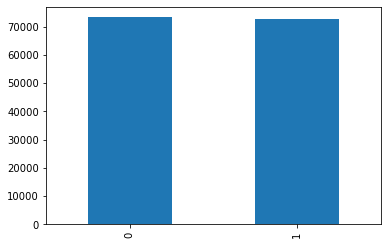

In [13]:
# 1: 긍정, 2: 부정
train['label'].value_counts().plot(kind = 'bar')

In [14]:
train.isnull().sum()

id          0
document    1
label       0
dtype: int64

In [15]:
train.loc[train['document'].isnull()]

,id,document,label
25857,2172111,NaN,1


In [16]:
train = train.dropna(how='any')
print(train.isnull().values.any())
print(len(train))

False
146182


### 테스트
---

In [17]:
test['document'].unique(), test['label'].unique()

(array(['굳 ㅋ', 'GDNTOPCLASSINTHECLUB',
        '뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아', ...,
        '그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다',
        '절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네', '마무리는 또 왜이래'],
       dtype=object),
 array([1, 0], dtype=int64))

In [18]:
# document 열과 label 열의 중복을 제외한 값의 개수
test['document'].nunique(), test['label'].nunique()

(49157, 2)

In [19]:
# document 열의 중복 제거
test.drop_duplicates(subset=['document'], inplace=True)

In [20]:
print(len(test))

49158


In [21]:
test['label'].value_counts()

1    24712
0    24446
Name: label, dtype: int64

In [22]:
test.groupby('label').count()

,id,document
label,,
0,24446,24446
1,24712,24711


<AxesSubplot:>

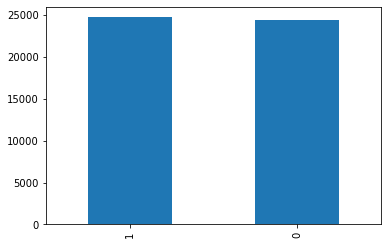

In [23]:
# 1: 긍정, 0: 부정
test['label'].value_counts().plot(kind = 'bar')

In [24]:
test.isnull().sum()

id          0
document    1
label       0
dtype: int64

In [25]:
test.loc[test['document'].isnull()]

,id,document,label
5746,402110,NaN,1


In [26]:
test = test.dropna(how='any')
print(test.isnull().values.any())
print(len(test))

False
49157


### 한글 정규 표현식
- https://codingspooning.tistory.com/138

In [27]:
# 한글과 공백을 제외하고 모두 제거
train['document'] = train['document'].str.replace('[^ ㄱ-ㅣ가-힣+]', '')
train.head()

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [28]:
test['document'] = test['document'].str.replace('[^ ㅣ가-힣+]', '')
test.head()

,id,document,label
0,6270596,굳,1
1,9274899,,0
2,8544678,뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임 돈주고 보기에는,0
4,6723715,만 아니었어도 별 다섯 개 줬을텐데 왜 로 나와서 제 심기를 불편하게 하죠,0


In [29]:
# 기존에 한글이 없는 리뷰의 빈 값을 Null 값으로 변경
# white space 데이터를 empty value로 변경
train['document'] = train['document'].str.replace('^ +', "")
test['document'] = test['document'].str.replace('^ +', "")

train['document'].replace('', np.nan, inplace=True)
test['document'].replace('', np.nan, inplace=True)

print(train.isnull().sum())
print(test.isnull().sum())

id            0
document    785
label         0
dtype: int64
id            0
document    373
label         0
dtype: int64


In [30]:
train.loc[train.document.isnull()][:5]

,id,document,label
404,4221289,NaN,0
412,9509970,NaN,1
470,10147571,NaN,1
584,7117896,NaN,0
593,6478189,NaN,0


In [31]:
test.loc[test.document.isnull()][:5]

,id,document,label
1,9274899,NaN,0
116,6910486,NaN,1
254,4976468,NaN,0
468,7517102,NaN,0
504,2096424,NaN,0


In [41]:
train = train.dropna(how = 'any')
test = test.dropna(how = 'any')
print('전처리 후 훈련용 샘플 개수 :', len(train))
print('전처리 후 테스트용 샘플 개수 :', len(test))

전처리 후 훈련용 샘플 개수 : 145397
전처리 후 테스트용 샘플 개수 : 48784


## 토큰화
---
- 불용어 제거

In [42]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [43]:
okt = Okt()
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem = True)

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

In [44]:
X_train = []
for sentence in tqdm(train['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|█████████████████████████████████████████████████████████████████████████| 145397/145397 [14:55<00:00, 162.27it/s]


In [45]:
print(X_train[:5])

[['아', '더빙', '진짜', '짜증나다', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'], ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다'], ['교도소', '이야기', '구먼', '솔직하다', '재미', '없다', '평점', '조정'], ['사이', '몬페', '그', '익살스럽다', '연기', '돋보이다', '영화', '스파이더맨', '에서', '늙다', '보이다', '커스틴', '던스트', '너무나도', '이쁘다', '보이다']]


In [46]:
X_test = []
for sentence in tqdm(test['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|███████████████████████████████████████████████████████████████████████████| 48784/48784 [06:36<00:00, 122.93it/s]


In [47]:
print(X_test[:5])

[['굳다'], ['뭐', '야', '평점', '나쁘다', '않다', '점', '짜다', '리', '더', '더욱', '아니다'], ['지루하다', '않다', '완전', '막장', '임', '돈', '주다', '보기', '에는'], ['만', '아니다', '별', '다섯', '개', '주다', '왜', '로', '나오다', '제', '심기', '불편하다'], ['음악', '주가', '되다', '최고', '음악', '영화']]


## 정수 인코딩
---

In [49]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [50]:
print(tokenizer.word_index)

{'영화': 1, '보다': 2, '을': 3, '없다': 4, '이다': 5, '있다': 6, '좋다': 7, '너무': 8, '다': 9, '정말': 10, '되다': 11, '재밌다': 12, '적': 13, '만': 14, '같다': 15, '진짜': 16, '로': 17, '아니다': 18, '않다': 19, '점': 20, '에서': 21, '만들다': 22, '나오다': 23, '연기': 24, '것': 25, '평점': 26, '내': 27, '최고': 28, '그': 29, '나': 30, '안': 31, '인': 32, '스토리': 33, '생각': 34, '못': 35, '왜': 36, '드라마': 37, '게': 38, '감동': 39, '사람': 40, '보고': 41, '이렇다': 42, '말': 43, '고': 44, '아깝다': 45, '더': 46, '배우': 47, '때': 48, 'ㅋㅋ': 49, '아': 50, '감독': 51, '거': 52, '그냥': 53, '재미있다': 54, '요': 55, '재미': 56, '시간': 57, '내용': 58, '뭐': 59, '까지': 60, '중': 61, '주다': 62, '자다': 63, '하고': 64, '지루하다': 65, '재미없다': 66, '쓰레기': 67, '수': 68, '네': 69, '모르다': 70, '가다': 71, '들다': 72, '그렇다': 73, '싶다': 74, '지': 75, '작품': 76, '사랑': 77, '알다': 78, '하나': 79, '다시': 80, '마지막': 81, '볼': 82, '이건': 83, '정도': 84, '저': 85, '완전': 86, '오다': 87, 'ㅋ': 88, 'ㅠㅠ': 89, '많다': 90, '처음': 91, 'ㅋㅋㅋ': 92, '장면': 93, '액션': 94, '주인공': 95, '이렇게': 96, '안되다': 97, '걸': 98, '차다': 99, '나다': 100, '개': 101, '하': 1

In [51]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 43759
등장 빈도가 2번 이하인 희귀 단어의 수: 24342
단어 집합에서 희귀 단어의 비율: 55.62741378916337
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.8712453218866953


In [52]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 19418


In [53]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [54]:
print(X_train[:3])

[[50, 455, 16, 260, 660], [934, 457, 41, 603, 1, 214, 1450, 24, 962, 676, 19], [386, 2445, 2316, 5674, 2, 222, 9]]


In [55]:
print(X_test[:3])

[[747], [59, 162, 26, 428, 19, 20, 295, 881, 46, 786, 18], [65, 19, 86, 337, 109, 104, 62, 149, 275]]


In [56]:
y_train = np.array(train['label'])
y_test = np.array(test['label'])

## 빈 샘플(empty samples) 제거

In [57]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [58]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

145165
145165


## 패딩

리뷰의 최대 길이 : 69
리뷰의 평균 길이 : 10.81572004271002


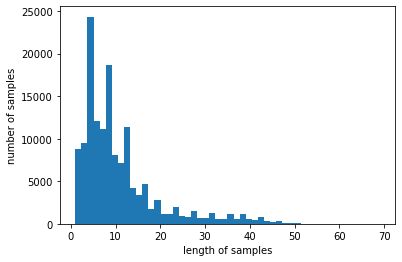

In [59]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [60]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [63]:
max_len = 35
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 35 이하인 샘플의 비율: 96.3510488065305


In [64]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [65]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [66]:
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
1814/1815 [============================>.] - ETA: 0s - loss: 0.3901 - acc: 0.8224
Epoch 1: val_acc improved from -inf to 0.84314, saving model to best_model.h5
1815/1815 [==============================] - 63s 34ms/step - loss: 0.3901 - acc: 0.8224 - val_loss: 0.3586 - val_acc: 0.8431
Epoch 2/15
1815/1815 [==============================] - ETA: 0s - loss: 0.3263 - acc: 0.8587
Epoch 2: val_acc improved from 0.84314 to 0.85768, saving model to best_model.h5
1815/1815 [==============================] - 73s 40ms/step - loss: 0.3263 - acc: 0.8587 - val_loss: 0.3311 - val_acc: 0.8577
Epoch 3/15
1814/1815 [============================>.] - ETA: 0s - loss: 0.3009 - acc: 0.8725
Epoch 3: val_acc improved from 0.85768 to 0.86071, saving model to best_model.h5
1815/1815 [==============================] - 108s 59ms/step - loss: 0.3009 - acc: 0.8725 - val_loss: 0.3236 - val_acc: 0.8607
Epoch 4/15
1814/1815 [============================>.] - ETA: 0s - loss: 0.2809 - acc: 0.8828
Epoch 4: val

In [33]:
# tlabel=train['label'].value_counts()
# tlabel[0], tlabel[1]
# plt.bar(1, tlabel[0])
# plt.bar(2, tlabel[1])
# plt.show()